<a href="https://colab.research.google.com/github/PramodK1953/Vehicle-Tracking-and-Numberplate-Recognition/blob/main/main_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OCR Maps

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
!pip install easyocr
!pip install imutils
!pip install opencv-python-headless==4.1.2.30
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr 

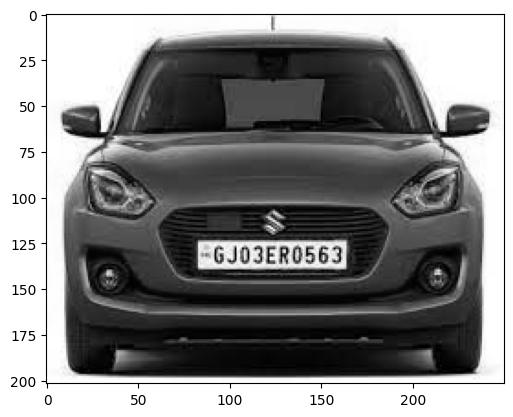

In [4]:
img = cv2.imread('/content/demo img.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

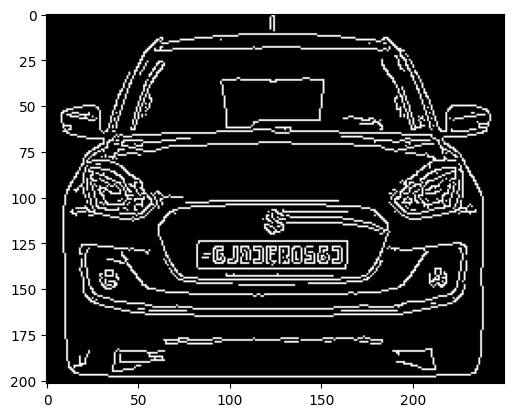

In [5]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [6]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [7]:
location = None
for contour in contours:
  approx = cv2.approxPolyDP(contour, 10, True)
  if len(approx) == 4:
    location = approx

In [8]:
location

array([[[ 82, 126]],

       [[163, 124]],

       [[164, 136]],

       [[ 83, 139]]], dtype=int32)

In [9]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

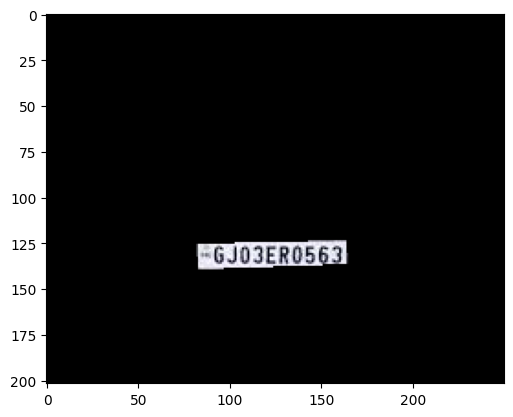

In [10]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [11]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

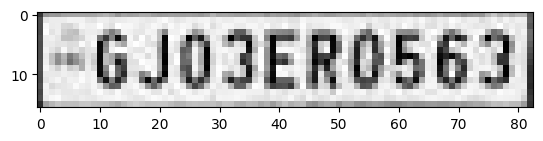

In [12]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [13]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[([[1, 1], [83, 1], [83, 16], [1, 16]], '~6JO3ER0563', 0.7230813033011808)]

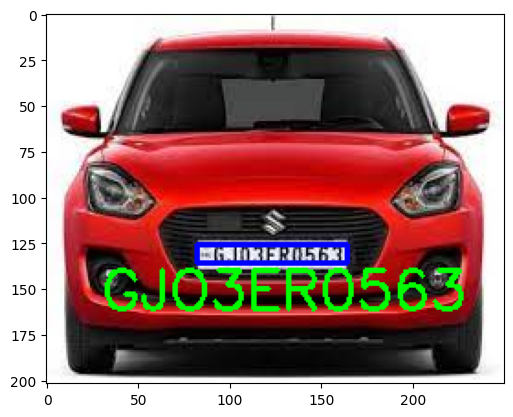

In [14]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, 
                   fontScale=1, color=(0,255,0), thickness=2)
res = cv2.rectangle(img, tuple(location[0][0]), tuple(location[2][0]), (255,0,0),2)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## DeepSORT Approach

In [1]:
import struct
import numpy as np
import colorsys
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import add
# from keras.layers.merge import add, concatenate
from keras.models import Model

In [2]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) 
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', 
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) 
                    gamma = self.read_bytes(size) 
                    mean  = self.read_bytes(size) 
                    var   = self.read_bytes(size) 
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))
    def reset(self):
        self.offset = 0

In [3]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
# from keras.preprocessing.image import load_img, img_to_array
import cv2
import random

In [4]:
label_map = {
    "bicycle": "yellow", 
    "car": "red",
    "truck": "green",
    "motorbike": "white", 
    "bus": "white",
    "train": "white", 
}
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w 
            y = (row + y) / grid_h 
            w = anchors[2 * b + 0] * np.exp(w) / net_w 
            h = anchors[2 * b + 1] * np.exp(h) / net_h 
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
def load_image_pixels(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    return image, width, height
def image_preprocess(image, target_size):
    ih, iw    = target_size
    h,  w, _  = image.shape
    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))
    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.
    image_expanded = expand_dims(image_paded, 0)
    return image_expanded, w, h
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    return v_boxes, v_labels, v_scores
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color=label_map[v_labels[i]])
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color=label_map[v_labels[i]])
    pyplot.show()
    
def draw_bbox(image, bboxes, CLASSES, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):   
    NUM_CLASS = CLASSES
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = (0, 0, 255)
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)
    return image

In [5]:
NUM_CLASS = {
    1: 'bicycle',
    2: 'car',
    3: 'motorbike',
    5: 'bus',
    7: 'truck'
}

In [6]:
!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights

--2023-05-13 07:46:06--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.4MB/s    in 12s     

2023-05-13 07:46:19 (19.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [7]:
model = make_yolov3_model()
weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(model)

model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

loading weights of convolution #81
no convolution #82
no convolution #83
loading weights of convolution #84
no convolution #85
no convolution #86
loading weights of convolution #87
loading weights of convolution #88
loading weights of convolution #89
loading weights of convolution #90
loading weights of convolution #91
loading weights of convolution #92
loading weights of convolution #93
no convolution #94
no convolution #95
loading weights of convolution #96
no convolution #97
no convolution #98
loading weights of convolution #99
loading weights of convolution #100
loading weights of convolution #101
loading weights of convolution #102
loading weights of convolution #103
loading weights of convolution #104
loading weights of convolution #105


In [8]:
from keras.models import load_model
model = load_model('model.h5')

In [9]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
WIDTH, HEIGHT = 416, 416
class_threshold = 0.8

In [10]:
import os
import errno
import argparse
import numpy as np
import cv2
import tensorflow.compat.v1 as tf
import scipy.linalg
from scipy.optimize import linear_sum_assignment

In [11]:
class Detection(object):
    def __init__(self, tlwh, confidence, class_name, feature):
        self.tlwh = np.asarray(tlwh, dtype=np.float)
        self.confidence = float(confidence)
        self.class_name = class_name
        self.feature = np.asarray(feature, dtype=np.float32)

    def get_class(self):
        return self.class_name

    def to_tlbr(self):
        ret = self.tlwh.copy()
        ret[2:] += ret[:2]
        return ret

    def to_xyah(self):
        ret = self.tlwh.copy()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

class ImageEncoder(object):

    def __init__(self, checkpoint_filename, input_name="images", output_name="features"):
        self.session = tf.Session()
        with tf.gfile.GFile(checkpoint_filename, "rb") as file_handle:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(file_handle.read())
        tf.import_graph_def(graph_def)
        try:
            self.input_var = tf.get_default_graph().get_tensor_by_name(input_name)
            self.output_var = tf.get_default_graph().get_tensor_by_name(output_name)
        except KeyError:
            layers = [i.name for i in tf.get_default_graph().get_operations()]
            self.input_var = tf.get_default_graph().get_tensor_by_name(layers[0]+':0')
            self.output_var = tf.get_default_graph().get_tensor_by_name(layers[-1]+':0')            

        assert len(self.output_var.get_shape()) == 2
        assert len(self.input_var.get_shape()) == 4
        self.feature_dim = self.output_var.get_shape().as_list()[-1]
        self.image_shape = self.input_var.get_shape().as_list()[1:]

    def __call__(self, data_x, batch_size=32):
        out = np.zeros((len(data_x), self.feature_dim), np.float32)
        _run_in_batches(
            lambda x: self.session.run(self.output_var, feed_dict=x),
            {self.input_var: data_x}, out, batch_size)
        return out
def _run_in_batches(f, data_dict, out, batch_size):
    data_len = len(out)
    num_batches = int(data_len / batch_size)

    s, e = 0, 0
    for i in range(num_batches):
        s, e = i * batch_size, (i + 1) * batch_size
        batch_data_dict = {k: v[s:e] for k, v in data_dict.items()}
        out[s:e] = f(batch_data_dict)
    if e < len(out):
        batch_data_dict = {k: v[e:] for k, v in data_dict.items()}
        out[e:] = f(batch_data_dict)


def extract_image_patch(image, bbox, patch_shape):
    bbox = np.array(bbox)
    if patch_shape is not None:
       
        target_aspect = float(patch_shape[1]) / patch_shape[0]
        new_width = target_aspect * bbox[3]
        bbox[0] -= (new_width - bbox[2]) / 2
        bbox[2] = new_width

   
    bbox[2:] += bbox[:2]
    bbox = bbox.astype(np.int)

   
    bbox[:2] = np.maximum(0, bbox[:2])
    bbox[2:] = np.minimum(np.asarray(image.shape[:2][::-1]) - 1, bbox[2:])
    if np.any(bbox[:2] >= bbox[2:]):
        return None
    sx, sy, ex, ey = bbox
    image = image[sy:ey, sx:ex]
    image = cv2.resize(image, tuple(patch_shape[::-1]))
    return image

def create_box_encoder(model_filename, input_name="images:0", output_name="features:0", batch_size=32):
    image_encoder = ImageEncoder(model_filename, input_name, output_name)
    image_shape = image_encoder.image_shape

    def encoder(image, boxes):
        image_patches = []
        for box in boxes:
            patch = extract_image_patch(image, box, image_shape[:2])
            if patch is None:
                print("WARNING: Failed to extract image patch: %s." % str(box))
                patch = np.random.uniform(0., 255., image_shape).astype(np.uint8)
            image_patches.append(patch)
        image_patches = np.asarray(image_patches)
        return image_encoder(image_patches, batch_size)

    return encoder


def generate_detections(encoder, mot_dir, output_dir, detection_dir=None):
    if detection_dir is None:
        detection_dir = mot_dir
    try:
        os.makedirs(output_dir)
    except OSError as exception:
        if exception.errno == errno.EEXIST and os.path.isdir(output_dir):
            pass
        else:
            raise ValueError(
                "Failed to created output directory '%s'" % output_dir)
    for sequence in os.listdir(mot_dir):
        print("Processing %s" % sequence)
        sequence_dir = os.path.join(mot_dir, sequence)
        image_dir = os.path.join(sequence_dir, "img1")
        image_filenames = {
            int(os.path.splitext(f)[0]): os.path.join(image_dir, f)
            for f in os.listdir(image_dir)}
        detection_file = os.path.join(
            detection_dir, sequence, "det/det.txt")
        detections_in = np.loadtxt(detection_file, delimiter=',')
        detections_out = []
        frame_indices = detections_in[:, 0].astype(np.int)
        min_frame_idx = frame_indices.astype(np.int).min()
        max_frame_idx = frame_indices.astype(np.int).max()
        for frame_idx in range(min_frame_idx, max_frame_idx + 1):
            print("Frame %05d/%05d" % (frame_idx, max_frame_idx))
            mask = frame_indices == frame_idx
            rows = detections_in[mask]
            if frame_idx not in image_filenames:
                print("WARNING could not find image for frame %d" % frame_idx)
                continue
            bgr_image = cv2.imread(
                image_filenames[frame_idx], cv2.IMREAD_COLOR)
            features = encoder(bgr_image, rows[:, 2:6].copy())
            detections_out += [np.r_[(row, feature)] for row, feature
                               in zip(rows, features)]
        output_filename = os.path.join(output_dir, "%s.npy" % sequence)
        np.save(
            output_filename, np.asarray(detections_out), allow_pickle=False)

In [12]:
!wget https://github.com/anushkadhiman/ObjectTracking-DeepSORT-YOLOv3-TF2/raw/master/model_data/coco/mars-small128.pb

--2023-05-13 07:46:30--  https://github.com/anushkadhiman/ObjectTracking-DeepSORT-YOLOv3-TF2/raw/master/model_data/coco/mars-small128.pb
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/anushkadhiman/ObjectTracking-DeepSORT-YOLOv3-TF2/master/model_data/coco/mars-small128.pb [following]
--2023-05-13 07:46:30--  https://raw.githubusercontent.com/anushkadhiman/ObjectTracking-DeepSORT-YOLOv3-TF2/master/model_data/coco/mars-small128.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11244842 (11M) [application/octet-stream]
Saving to: ‘mars-small128.pb’

mars-small128.pb    100%[===================>] 

In [13]:
chi2inv95 = {
    1: 3.8415,
    2: 5.9915,
    3: 7.8147,
    4: 9.4877,
    5: 11.070,
    6: 12.592,
    7: 14.067,
    8: 15.507,
    9: 16.919}


class KalmanFilter(object):

    def __init__(self):
        ndim, dt = 4, 1.
        self._motion_mat = np.eye(2 * ndim, 2 * ndim)
        for i in range(ndim):
            self._motion_mat[i, ndim + i] = dt
        self._update_mat = np.eye(ndim, 2 * ndim)
        self._std_weight_position = 1. / 20
        self._std_weight_velocity = 1. / 160

    def initiate(self, measurement):
        mean_pos = measurement
        mean_vel = np.zeros_like(mean_pos)
        mean = np.r_[mean_pos, mean_vel]

        std = [
            2 * self._std_weight_position * measurement[3],
            2 * self._std_weight_position * measurement[3],
            1e-2,
            2 * self._std_weight_position * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            10 * self._std_weight_velocity * measurement[3],
            1e-5,
            10 * self._std_weight_velocity * measurement[3]]
        covariance = np.diag(np.square(std))
        return mean, covariance

    def predict(self, mean, covariance):
        std_pos = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-2,
            self._std_weight_position * mean[3]]
        std_vel = [
            self._std_weight_velocity * mean[3],
            self._std_weight_velocity * mean[3],
            1e-5,
            self._std_weight_velocity * mean[3]]
        motion_cov = np.diag(np.square(np.r_[std_pos, std_vel]))

        mean = np.dot(self._motion_mat, mean)
        covariance = np.linalg.multi_dot((
            self._motion_mat, covariance, self._motion_mat.T)) + motion_cov

        return mean, covariance

    def project(self, mean, covariance):
        std = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-1,
            self._std_weight_position * mean[3]]
        innovation_cov = np.diag(np.square(std))

        mean = np.dot(self._update_mat, mean)
        covariance = np.linalg.multi_dot((
            self._update_mat, covariance, self._update_mat.T))
        return mean, covariance + innovation_cov

    def update(self, mean, covariance, measurement):
        projected_mean, projected_cov = self.project(mean, covariance)

        chol_factor, lower = scipy.linalg.cho_factor(
            projected_cov, lower=True, check_finite=False)
        kalman_gain = scipy.linalg.cho_solve(
            (chol_factor, lower), np.dot(covariance, self._update_mat.T).T,
            check_finite=False).T
        innovation = measurement - projected_mean

        new_mean = mean + np.dot(innovation, kalman_gain.T)
        new_covariance = covariance - np.linalg.multi_dot((
            kalman_gain, projected_cov, kalman_gain.T))
        return new_mean, new_covariance

    def gating_distance(self, mean, covariance, measurements,
                        only_position=False):
        mean, covariance = self.project(mean, covariance)
        if only_position:
            mean, covariance = mean[:2], covariance[:2, :2]
            measurements = measurements[:, :2]

        cholesky_factor = np.linalg.cholesky(covariance)
        d = measurements - mean
        z = scipy.linalg.solve_triangular(
            cholesky_factor, d.T, lower=True, check_finite=False,
            overwrite_b=True)
        squared_maha = np.sum(z * z, axis=0)
        return squared_maha

In [14]:
INFTY_COST = 1e+5


def min_cost_matching(
        distance_metric, max_distance, tracks, detections, track_indices=None,
        detection_indices=None):
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    if len(detection_indices) == 0 or len(track_indices) == 0:
        return [], track_indices, detection_indices  

    cost_matrix = distance_metric(
        tracks, detections, track_indices, detection_indices)
    cost_matrix[cost_matrix > max_distance] = max_distance + 1e-5
    indices = linear_sum_assignment(cost_matrix)
    indices = np.asarray(indices)
    indices = np.transpose(indices)
    matches, unmatched_tracks, unmatched_detections = [], [], []
    for col, detection_idx in enumerate(detection_indices):
        if col not in indices[:, 1]:
            unmatched_detections.append(detection_idx)
    for row, track_idx in enumerate(track_indices):
        if row not in indices[:, 0]:
            unmatched_tracks.append(track_idx)
    for row, col in indices:
        track_idx = track_indices[row]
        detection_idx = detection_indices[col]
        if cost_matrix[row, col] > max_distance:
            unmatched_tracks.append(track_idx)
            unmatched_detections.append(detection_idx)
        else:
            matches.append((track_idx, detection_idx))
    return matches, unmatched_tracks, unmatched_detections


def matching_cascade(
        distance_metric, max_distance, cascade_depth, tracks, detections,
        track_indices=None, detection_indices=None):

    if track_indices is None:
        track_indices = list(range(len(tracks)))
    if detection_indices is None:
        detection_indices = list(range(len(detections)))

    unmatched_detections = detection_indices
    matches = []
    for level in range(cascade_depth):
        if len(unmatched_detections) == 0: 
            break

        track_indices_l = [
            k for k in track_indices
            if tracks[k].time_since_update == 1 + level
        ]
        if len(track_indices_l) == 0:  
            continue

        matches_l, _, unmatched_detections = \
            min_cost_matching(
                distance_metric, max_distance, tracks, detections,
                track_indices_l, unmatched_detections)
        matches += matches_l
    unmatched_tracks = list(set(track_indices) - set(k for k, _ in matches))
    return matches, unmatched_tracks, unmatched_detections


def gate_cost_matrix(
        kf, cost_matrix, tracks, detections, track_indices, detection_indices,
        gated_cost=INFTY_COST, only_position=False):
    gating_dim = 2 if only_position else 4
    gating_threshold = chi2inv95[gating_dim]
    measurements = np.asarray(
        [detections[i].to_xyah() for i in detection_indices])
    for row, track_idx in enumerate(track_indices):
        track = tracks[track_idx]
        gating_distance = kf.gating_distance(
            track.mean, track.covariance, measurements, only_position)
        cost_matrix[row, gating_distance > gating_threshold] = gated_cost
    return cost_matrix

In [15]:
def iou(bbox, candidates):
    bbox_tl, bbox_br = bbox[:2], bbox[:2] + bbox[2:]
    candidates_tl = candidates[:, :2]
    candidates_br = candidates[:, :2] + candidates[:, 2:]

    tl = np.c_[np.maximum(bbox_tl[0], candidates_tl[:, 0])[:, np.newaxis],
               np.maximum(bbox_tl[1], candidates_tl[:, 1])[:, np.newaxis]]
    br = np.c_[np.minimum(bbox_br[0], candidates_br[:, 0])[:, np.newaxis],
               np.minimum(bbox_br[1], candidates_br[:, 1])[:, np.newaxis]]
    wh = np.maximum(0., br - tl)

    area_intersection = wh.prod(axis=1)
    area_bbox = bbox[2:].prod()
    area_candidates = candidates[:, 2:].prod(axis=1)
    return area_intersection / (area_bbox + area_candidates - area_intersection)


def iou_cost(tracks, detections, track_indices=None,
             detection_indices=None):
    if track_indices is None:
        track_indices = np.arange(len(tracks))
    if detection_indices is None:
        detection_indices = np.arange(len(detections))

    cost_matrix = np.zeros((len(track_indices), len(detection_indices)))
    for row, track_idx in enumerate(track_indices):
        if tracks[track_idx].time_since_update > 1:
            cost_matrix[row, :] = linear_assignment.INFTY_COST
            continue

        bbox = tracks[track_idx].to_tlwh()
        candidates = np.asarray([detections[i].tlwh for i in detection_indices])
        cost_matrix[row, :] = 1. - iou(bbox, candidates)
    return cost_matrix

In [16]:
def non_max_suppression(boxes, classes, max_bbox_overlap, scores=None):
    if len(boxes) == 0:
        return []

    boxes = boxes.astype(np.float)
    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + boxes[:, 0]
    y2 = boxes[:, 3] + boxes[:, 1]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    if scores is not None:
        idxs = np.argsort(scores)
    else:
        idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(
            idxs, np.concatenate(
                ([last], np.where(overlap > max_bbox_overlap)[0])))

    return pick

In [17]:
def _pdist(a, b):
    a, b = np.asarray(a), np.asarray(b)
    if len(a) == 0 or len(b) == 0:
        return np.zeros((len(a), len(b)))
    a2, b2 = np.square(a).sum(axis=1), np.square(b).sum(axis=1)
    r2 = -2. * np.dot(a, b.T) + a2[:, None] + b2[None, :]
    r2 = np.clip(r2, 0., float(np.inf))
    return r2


def _cosine_distance(a, b, data_is_normalized=False):
    if not data_is_normalized:
        a = np.asarray(a) / np.linalg.norm(a, axis=1, keepdims=True)
        b = np.asarray(b) / np.linalg.norm(b, axis=1, keepdims=True)
    return 1. - np.dot(a, b.T)


def _nn_euclidean_distance(x, y):
    distances = _pdist(x, y)
    return np.maximum(0.0, distances.min(axis=0))


def _nn_cosine_distance(x, y):
    distances = _cosine_distance(x, y)
    return distances.min(axis=0)


class NearestNeighborDistanceMetric(object):

    def __init__(self, metric, matching_threshold, budget=None):


        if metric == "euclidean":
            self._metric = _nn_euclidean_distance
        elif metric == "cosine":
            self._metric = _nn_cosine_distance
        else:
            raise ValueError(
                "Invalid metric; must be either 'euclidean' or 'cosine'")
        self.matching_threshold = matching_threshold
        self.budget = budget
        self.samples = {}

    def partial_fit(self, features, targets, active_targets):
        for feature, target in zip(features, targets):
            self.samples.setdefault(target, []).append(feature)
            if self.budget is not None:
                self.samples[target] = self.samples[target][-self.budget:]
        self.samples = {k: self.samples[k] for k in active_targets}

    def distance(self, features, targets):
        cost_matrix = np.zeros((len(targets), len(features)))
        for i, target in enumerate(targets):
            cost_matrix[i, :] = self._metric(self.samples[target], features)
        return cost_matrix

In [18]:
class TrackState:

    Tentative = 1
    Confirmed = 2
    Deleted = 3


class Track:

    def __init__(self, mean, covariance, track_id, n_init, max_age,
                 feature=None, class_name=None):
        self.mean = mean
        self.covariance = covariance
        self.track_id = track_id
        self.hits = 1
        self.age = 1
        self.time_since_update = 0

        self.state = TrackState.Tentative
        self.features = []
        if feature is not None:
            self.features.append(feature)

        self._n_init = n_init
        self._max_age = max_age
        self.class_name = class_name

    def to_tlwh(self):
       
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    def to_tlbr(self):
        
        ret = self.to_tlwh()
        ret[2:] = ret[:2] + ret[2:]
        return ret
    
    def get_class(self):
        return self.class_name

    def predict(self, kf):
        self.mean, self.covariance = kf.predict(self.mean, self.covariance)
        self.age += 1
        self.time_since_update += 1

    def update(self, kf, detection):
        self.mean, self.covariance = kf.update(
            self.mean, self.covariance, detection.to_xyah())
        self.features.append(detection.feature)

        self.hits += 1
        self.time_since_update = 0
        if self.state == TrackState.Tentative and self.hits >= self._n_init:
            self.state = TrackState.Confirmed

    def mark_missed(self):
        if self.state == TrackState.Tentative:
            self.state = TrackState.Deleted
        elif self.time_since_update > self._max_age:
            self.state = TrackState.Deleted

    def is_tentative(self):
        return self.state == TrackState.Tentative

    def is_confirmed(self):
        return self.state == TrackState.Confirmed

    def is_deleted(self):
        return self.state == TrackState.Deleted

In [19]:
class Tracker:
    def __init__(self, metric, max_iou_distance=0.7, max_age=30, n_init=3):
        self.metric = metric
        self.max_iou_distance = max_iou_distance
        self.max_age = max_age
        self.n_init = n_init

        self.kf = KalmanFilter()
        self.tracks = []
        self._next_id = 1

    def predict(self):
        for track in self.tracks:
            track.predict(self.kf)

    def update(self, detections):
        matches, unmatched_tracks, unmatched_detections = \
            self._match(detections)
        for track_idx, detection_idx in matches:
            self.tracks[track_idx].update(
                self.kf, detections[detection_idx])
        for track_idx in unmatched_tracks:
            self.tracks[track_idx].mark_missed()
        for detection_idx in unmatched_detections:
            self._initiate_track(detections[detection_idx])
        self.tracks = [t for t in self.tracks if not t.is_deleted()]
        active_targets = [t.track_id for t in self.tracks if t.is_confirmed()]
        features, targets = [], []
        for track in self.tracks:
            if not track.is_confirmed():
                continue
            features += track.features
            targets += [track.track_id for _ in track.features]
            track.features = []
        self.metric.partial_fit(
            np.asarray(features), np.asarray(targets), active_targets)

    def _match(self, detections):

        def gated_metric(tracks, dets, track_indices, detection_indices):
            features = np.array([dets[i].feature for i in detection_indices])
            targets = np.array([tracks[i].track_id for i in track_indices])
            cost_matrix = self.metric.distance(features, targets)
            cost_matrix = gate_cost_matrix(
                self.kf, cost_matrix, tracks, dets, track_indices,
                detection_indices)

            return cost_matrix
        confirmed_tracks = [
            i for i, t in enumerate(self.tracks) if t.is_confirmed()]
        unconfirmed_tracks = [
            i for i, t in enumerate(self.tracks) if not t.is_confirmed()]
        matches_a, unmatched_tracks_a, unmatched_detections = \
                matching_cascade(
                gated_metric, self.metric.matching_threshold, self.max_age,
                self.tracks, detections, confirmed_tracks)
        iou_track_candidates = unconfirmed_tracks + [
            k for k in unmatched_tracks_a if
            self.tracks[k].time_since_update == 1]
        unmatched_tracks_a = [
            k for k in unmatched_tracks_a if
            self.tracks[k].time_since_update != 1]
        matches_b, unmatched_tracks_b, unmatched_detections = \
                min_cost_matching(
                iou_cost, self.max_iou_distance, self.tracks,
                detections, iou_track_candidates, unmatched_detections)

        matches = matches_a + matches_b
        unmatched_tracks = list(set(unmatched_tracks_a + unmatched_tracks_b))
        return matches, unmatched_tracks, unmatched_detections

    def _initiate_track(self, detection):
        mean, covariance = self.kf.initiate(detection.to_xyah())
        class_name = detection.get_class()
        self.tracks.append(Track(
            mean, covariance, self._next_id, self.n_init, self.max_age,
            detection.feature, class_name))
        self._next_id += 1

In [20]:
max_cosine_distance = 0.7
max_euclidean_distance = 0.7
nn_budget = None
model_filename = 'mars-small128.pb'

key_list = list(NUM_CLASS.keys()) 
val_list = list(NUM_CLASS.values())

In [21]:
import time
def object_tracking(video_path, output_path):
    encoder = create_box_encoder(model_filename, batch_size=1)
    metric = NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
    tracker = Tracker(metric)
    
    times, times_2 = [], []
    vid = cv2.VideoCapture(video_path)

    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vid.get(cv2.CAP_PROP_FPS))
    codec = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, codec, fps, (width, height))
    
    while True:
        _, frame = vid.read()

        try:
            original_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            original_frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)
        except:
            break

        image_data, image_w, image_h = image_preprocess(np.copy(original_frame), (WIDTH, HEIGHT))

        t1 = time.time()
        yhat = model.predict(image_data)

        boxes = list()
        for i in range(len(yhat)):
            boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)

        correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

        do_nms(boxes, 0.3)

        labels = ["bicycle", "car", "motorbike", "bus", "train", "truck"]
        # labels = ["car"]
        v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

        #t1 = time.time()
        #pred_bbox = Yolo.predict(image_data)
        t2 = time.time()

        boxes = []
        names = []
        scores = []
        for box, label, score in zip(v_boxes, v_labels, v_scores):
            boxes.append([
                 box.xmin, box.ymin, 
                (box.xmax - box.xmin), (box.ymax - box.ymin) * 2])
            names.append(label)
            scores.append(score)

        boxes = np.array(boxes) 
        names = np.array(names)
        scores = np.array(scores)
        features = np.array(encoder(original_frame, boxes))
        detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in zip(boxes, scores, names, features)]

        tracker.predict()
        tracker.update(detections)

        tracked_bboxes = []
        for track in tracker.tracks:
            if not track.is_confirmed() or track.time_since_update > 5:
                continue 
            bbox = track.to_tlbr() 
            class_name = track.get_class() 
            tracking_id = track.track_id 
            index = key_list[val_list.index(class_name)] 
            tracked_bboxes.append(bbox.tolist() + [tracking_id, index]) 

        image = draw_bbox(original_frame, tracked_bboxes, CLASSES=NUM_CLASS, tracking=True)

        t3 = time.time()
        times.append(t2-t1)
        times_2.append(t3-t1)

        times = times[-20:]
        times_2 = times_2[-20:]

        ms = sum(times)/len(times)*1000
        fps = 1000 / ms
        fps2 = 1000 / (sum(times_2)/len(times_2)*1000)

        image = cv2.putText(image, "Time: {:.1f} FPS".format(fps), (0, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)

        #image = draw_bbox(image, bboxes, CLASSES=CLASSES, show_label=False, rectangle_colors=rectangle_colors, tracking=True)
        print("Time: {:.2f}ms, Detection FPS: {:.1f}, total FPS: {:.1f}".format(ms, fps, fps2))
        out.write(image)

    out.release()
    vid.release()

In [ ]:
import os

VIDEO_PATH = '/content/Inputs/'
videos = os.listdir(VIDEO_PATH)

for video in videos:
    print(f"Processing video {video}")
    object_tracking(VIDEO_PATH + video, video)

Processing video For track.mp4
1/1 [==============================] - 10s 10s/step
Time: 14487.61ms, Detection FPS: 0.1, total FPS: 0.1
1/1 [==============================] - 0s 33ms/step


<ipython-input-11-adef3347218f>:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbox = bbox.astype(np.int)


Time: 8716.47ms, Detection FPS: 0.1, total FPS: 0.1
1/1 [==============================] - 0s 28ms/step


<ipython-input-11-adef3347218f>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tlwh = np.asarray(tlwh, dtype=np.float)


Time: 7164.92ms, Detection FPS: 0.1, total FPS: 0.1
1/1 [==============================] - 0s 28ms/step
Time: 6107.27ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 27ms/step
Time: 5463.03ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 30ms/step
Time: 5051.83ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 28ms/step
Time: 4929.33ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 30ms/step
Time: 4683.17ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 43ms/step
Time: 4478.69ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 46ms/step
Time: 4319.50ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 47ms/step
Time: 4309.74ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [==============================] - 0s 60ms/step
Time: 4191.32ms, Detection FPS: 0.2, total FPS: 0.2
1/1 [=======

## ByteTrack Approach

In [1]:
!nvidia-smi

Sat May 13 08:20:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()

In [3]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/content
--2023-05-13 08:23:24--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 142.251.171.102, 142.251.171.139, 142.251.171.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.171.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bmhl7n2pp7pm5hlqfor7lmlna51h0jc7/1683966150000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=811b8b53-e063-4168-bd69-2af559fdace8 [following]
--2023-05-13 08:23:25--  https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bmhl7n2pp7pm5hlqfor7lmlna51h0jc7/1683966150000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=811b8b53-e063-4168-bd69-2af559fdace8
Resolving doc-0s-ag-docs.googleusercontent.com (doc-0s-ag-docs.googleusercontent.com)... 142.

In [4]:
SOURCE_VIDEO_PATH = '/content/For track.mp4'

In [5]:
!pip install ultralytics
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.99 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.5/78.2 GB disk)


In [6]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt
!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install -q loguru lap

from IPython import display
display.clear_output()
import sys
sys.path.append(f"{HOME}/ByteTrack")
import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [7]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [8]:
!pip install supervision==0.1.0
from IPython import display
display.clear_output()
import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [9]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [10]:
from typing import List

import numpy as np
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))
    
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [11]:
MODEL = "yolov8x.pt"

In [12]:
from ultralytics import YOLO
model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 168MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [13]:
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [2, 3, 5, 7]


0: 384x640 2 persons, 4 cars, 70.4ms
Speed: 12.6ms preprocess, 70.4ms inference, 14.9ms postprocess per image at shape (1, 3, 640, 640)


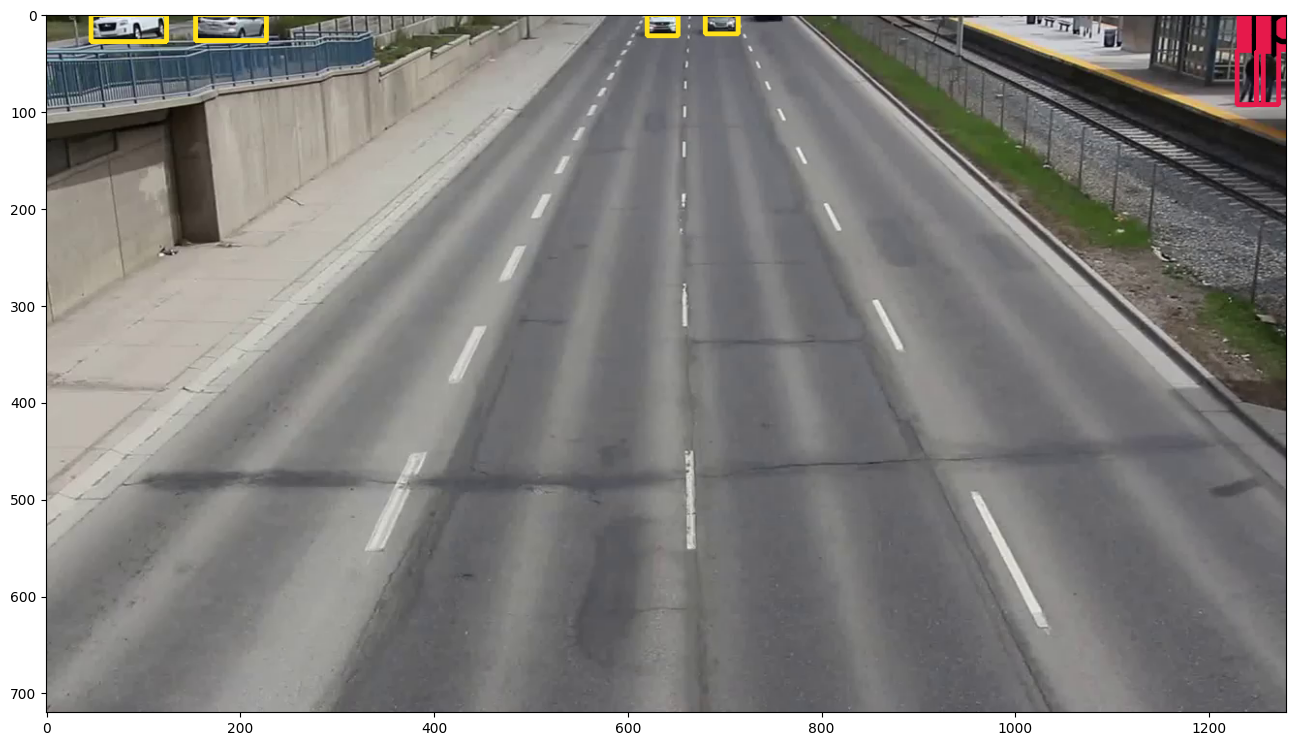

In [14]:
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
iterator = iter(generator)
frame = next(iterator)
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [15]:
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)
TARGET_VIDEO_PATH = f"{HOME}/video-result.mp4"

In [16]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=301)

In [17]:
from tqdm.notebook import tqdm
byte_tracker = BYTETracker(BYTETrackerArgs())

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

line_counter = LineCounter(start=LINE_START, end=LINE_END)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)


with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        line_counter.update(detections=detections)
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/301 [00:00<?, ?it/s]


0: 384x640 2 persons, 4 cars, 64.4ms
Speed: 2.2ms preprocess, 64.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 4 cars, 63.1ms
Speed: 2.5ms preprocess, 63.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 4 cars, 43.2ms
Speed: 2.5ms preprocess, 43.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 5 cars, 43.2ms
Speed: 1.8ms preprocess, 43.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 5 cars, 42.8ms
Speed: 2.2ms preprocess, 42.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 5 cars, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 5 cars, 40.2ms
Speed: 2.1ms preprocess, 40.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 5 cars, 30.8ms
Speed: 1.9ms prep

In [1]:
!pip install pipreqs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=9083ad744585062dae59134e3aae6b6a40942f1bbbc0f393f4819a18dc2706d4
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
!pipreqs

INFO: Successfully saved requirements file in /content/requirements.txt
